In [1]:
from utils import PROJECTS, computed_improvement, json_load, Mutation, MutationDecoder, TableBuilder as table
from collections import defaultdict
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch

%matplotlib inline

In [2]:
def load_symptoms():
    return { path.split('/')[3] : json_load(path, cls=MutationDecoder) for path in glob('../../subjects/*/results/symptoms.json') }

def full_count(aggregation):
    return sum( len(value) for value in aggregation.values() )

def combine(attempts):
    result = defaultdict(set)
    for it in attempts:
        for key, value in it.items():
            result[key].update(value)
    return dict(result)

In [3]:
targets = load_symptoms()
target_sizes = [ full_count(targets[proj]) for proj in PROJECTS ]
global_targets = combine ( values for values in targets.values() )

evosuite_improvement = computed_improvement()
dspot_improvement = computed_improvement('dspot')

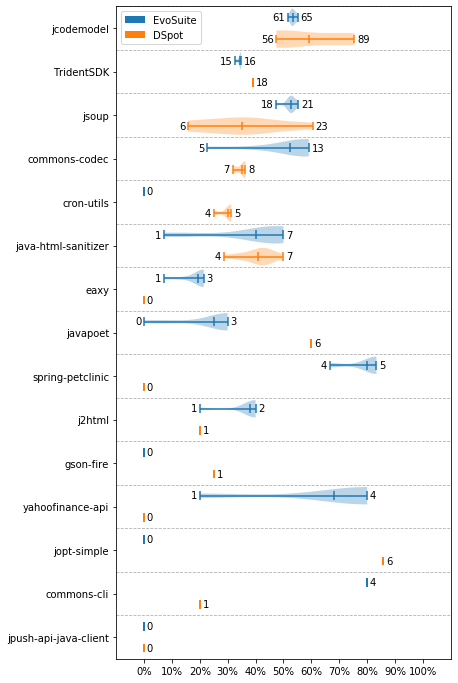

In [4]:
plt.rcParams['figure.figsize'] = [6, 12]

NULL = [0]

from matplotlib.ticker import MultipleLocator

def mean_point(segment):
    a = segment[0]
    b = segment[1]
    return (a[0] + b[0])/2, (a[1] + b[1])/2
    

def normalize_improvement(improvement):
    improvement_sizes = [[full_count(result) for result in improvement[proj]] for proj in PROJECTS]
    relative_improvement_sizes = [[isize/tsize for isize in sizes] for sizes,tsize in zip(improvement_sizes, target_sizes)]
    return relative_improvement_sizes

def min_max(improvement):
    sizes = [[full_count(result) for result in improvement[proj]] for proj in PROJECTS]
    return [ (min(values), max(values)) if values else (0, 0) for values in sizes ]

def plot_improvement(improvement, positions):
    figures = plt.violinplot(
        [size or NULL for size in normalize_improvement(improvement)], 
        vert=False, 
        widths=.8, 
        showmeans=True, 
        positions=positions
    )
    values = min_max(improvement)
    ax = plt.gca()
    offset = .01
    for (m,M), min_seg in zip(values, figures['cmins'].get_segments()):
        x, y = mean_point(min_seg)
        if m < M:
            ax.text(x - offset, y, str(m), horizontalalignment='right', verticalalignment='center')
    for (_,M), max_seg in zip(values, figures['cmaxes'].get_segments()):
        x, y = mean_point(max_seg)
        ax.text(x + offset, y, str(M), horizontalalignment='left', verticalalignment='center')

plt.xticks(np.arange(0., 1.1, step=.1))
plt.xlim(-0.1, 1.1)
plt.ylim(1, 2*len(PROJECTS) + 1)


ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(which='minor', length=0)

yticks = 2*np.arange(1, len(PROJECTS) + 1)
plt.yticks(yticks, PROJECTS)
plt.grid(True, linestyle='--', axis='y', which='minor')


plot_improvement(evosuite_improvement, yticks + .5)
plot_improvement(dspot_improvement, yticks - .5)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.legend(handles=[
    Patch(facecolor=colors[0], label='EvoSuite'),
    Patch(facecolor=colors[1], label='DSpot')], loc=2)



plt.savefig('improvement-distributions.pdf', dpi=300,bbox_inches='tight')


In [5]:
from IPython.display import display, HTML

def report_global_improvement(improvement):
    combined_improvement = { proj : combine(attempts) for proj, attempts in improvement.items() }
    global_improvement = combine( values for values in combined_improvement.values() )

    def row(symptom, solutions):
        solved = len(solutions)
        to_solve = len(global_targets[symptom])
        return symptom, solved, to_solve, f'{100*solved/to_solve:.0f}%'
    
    table(
        'Symptom', 
        'Improved', 
        'Total',  
        'Percent'
    ).display(
        row(symptom, solutions) for symptom, solutions in global_improvement.items() 
    )

def par(text):
    display(HTML(f'<p>{text}</p>'))

par('EvoSuite')                   
report_global_improvement(evosuite_improvement)
par('DSpot')
report_global_improvement(dspot_improvement)

Symptom,Improved,Total,Percent
no-infection,53,114,46%
no-propagation,55,115,48%
weak-oracle,38,83,46%


Symptom,Improved,Total,Percent
no-infection,57,114,50%
no-propagation,66,115,57%
weak-oracle,57,83,69%


In [6]:
def count(project, filename):
    return len(json_load(f'../../subjects/{project}/results/{filename}.json'))

table(
    'Project',
    'Generation targets',
    'Amplification targets',
).display(
    (project,
    count(project, 'generation-targets'),
    count(project, 'amplification-targets.close'))
    for project in PROJECTS
)

Project,Generation targets,Amplification targets
jpush-api-java-client,2,2
commons-cli,6,3
jopt-simple,2,3
yahoofinance-api,11,1
gson-fire,7,3
j2html,3,2
spring-petclinic,6,5
javapoet,10,10
eaxy,21,8
java-html-sanitizer,13,11


In [7]:
def improved_targets(improvement_report):
    result = set()
    for _, attempts in improvement_report.items():
        for aggregation in attempts:
            for _, solutions in aggregation.items():
                result.update(solutions)
    return result

evosuite_solutions = improved_targets(evosuite_improvement)
dspot_solutions = improved_targets(dspot_improvement)
both_solutions = evosuite_solutions.intersection(dspot_solutions)
all_solutions = evosuite_solutions.union(dspot_solutions)
evosuite_only_solutions = evosuite_solutions.difference(dspot_solutions)
dspot_only_solutions = dspot_solutions.difference(evosuite_solutions)

all_targets = set()
for _, value in global_targets.items():
    all_targets.update(value)
    
unsolved = all_targets.difference(all_solutions)

table().display(
    [
        ('EvoSuite', len(evosuite_solutions)),
        ('DSpot', len(dspot_solutions)),
        ('Both', len(both_solutions)),
        ('Evosuite only', len(evosuite_only_solutions)),
        ('DSpot only', len(dspot_only_solutions)),
        ('Any', len(all_solutions)),
        ('Unsolved', len(unsolved))
    ])

EvoSuite,146
DSpot,180
Both,87
Evosuite only,59
DSpot only,93
Any,239
Unsolved,73


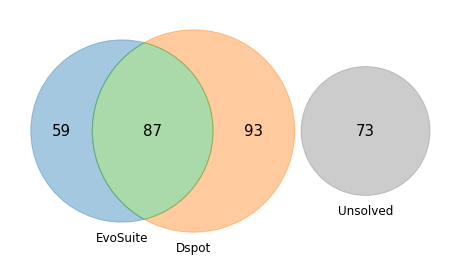

In [8]:
from matplotlib_venn import venn3

# venn_circles = venn2([evosuite_solutions, dspot_solutions], set_labels=['EvoSuite', 'Dspot'])
# venn_circles.get_patch_by_id('A').set_color(colors[0])
# venn_circles.get_patch_by_id('B').set_color(colors[1])
# venn_circles.get_patch_by_id('11').set_color(colors[2])

# for idx in ['10', '11', '01', 'A', 'B']:
#     venn_circles.get_label_by_id(idx).set_fontsize(20)

    
plt.rcParams['figure.figsize'] = [8, 7]

venn_circles = venn3([evosuite_solutions, dspot_solutions, unsolved], set_labels=['EvoSuite', 'Dspot', 'Unsolved'])

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

venn_circles.get_patch_by_id('100').set_color(colors[0])
venn_circles.get_patch_by_id('010').set_color(colors[1])
venn_circles.get_patch_by_id('001').set_color('gray')
venn_circles.get_patch_by_id('110').set_color(colors[2])

for idx in ['100', '110', '010', '001']:
    venn_circles.get_label_by_id(idx).set_fontsize(15)

plt.savefig('venn-diagram.pdf', dpi=300,bbox_inches='tight')

In [9]:
def report_solutions_by_symptom():
    def row(symptom):
        symptom_targets = global_targets[symptom]
        symptom_solved = all_solutions.intersection(symptom_targets)
        return (
            symptom, 
            len(evosuite_only_solutions.intersection(symptom_targets)),
            len(dspot_only_solutions.intersection(symptom_targets)),
            len(both_solutions.intersection(symptom_targets)),
            len(symptom_solved),
            f'{100*len(symptom_solved)/len(symptom_targets):0.2f}%',
            len(symptom_targets)
        )
    table(
        'Symptom', 
        'EvoSuite', 
        'DSpot', 
        'Both', 
        'Total', 
        'Percentage', 
        'Transformations'
    ).display(row(symptom) for symptom in ['no-infection', 'no-propagation', 'weak-oracle'])

report_solutions_by_symptom()

Symptom,EvoSuite,DSpot,Both,Total,Percentage,Transformations
no-infection,24,28,29,81,71.05%,114
no-propagation,26,37,29,92,80.00%,115
weak-oracle,9,28,29,66,79.52%,83
